In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive/SRGAN/

/content/drive/MyDrive/SRGAN


In [ ]:
%ls

256_ObjectCategories.tar  ids_path_vectors2               srgan1/
256_short_object/         image-super-resolution-master/  srgan2/
256_short_object.tar      index.bin                       train_std/
featuresresnet.pickle     index_path
ids_path_vectors1         Keras-SRGAN-master/


In [ ]:
#!pip install faiss-gpu

In [ ]:
#!pip install opencv-python==3.4.2.16
!pip install opencv-contrib-python==3.4.2.16

     |████████████████████████████████| 30.6MB 109kB/s 
  Found existing installation: opencv-contrib-python 4.1.2.30
    Uninstalling opencv-contrib-python-4.1.2.30:
      Successfully uninstalled opencv-contrib-python-4.1.2.30


In [ ]:
!apt-get install libomp-dev

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libomp5
Suggested packages:
  libomp-doc
The following NEW packages will be installed:
  libomp-dev libomp5
0 upgraded, 2 newly installed, 0 to remove and 13 not upgraded.
Need to get 239 kB of archives.
After this operation, 804 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libomp5 amd64 5.0.1-1 [234 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libomp-dev amd64 5.0.1-1 [5,088 B]
Fetched 239 kB in 1s (422 kB/s)
Selecting previously unselected package libomp5:amd64.
(Reading database ... 146374 files and directories currently installed.)
Preparing to unpack .../libomp5_5.0.1-1_amd64.deb ...
Unpacking libomp5:amd64 (5.0.1-1) ...
Selecting previously unselected package libomp-dev.
Preparing to unpack .../libomp-dev_5.0.1-1_amd64.deb ...
Unpacking libomp-dev (5.0.1-

In [ ]:
!pip install faiss-gpu==1.6.3

     |████████████████████████████████| 35.5MB 95kB/s 


In [ ]:
DEBUG = True


def GET_FAISS_RESOURCES():
    return None


def GET_FAISS_INDEX(index_path):
    #raise NotImplementedError
    import faiss
    index = faiss.read_index(index_path)
    return index


def GET_FAISS_ID_TO_VECTOR(ids_vectors_path):
    #raise NotImplementedError
    import pickle
    import os
    if not os.path.exists(ids_vectors_path):
      return None
    with open(ids_vectors_path, 'rb') as f:
      index_dict = pickle.load(f)
    def id_to_vector(id_):
      try:
        return index_dict[id_]
      except:
        pass
    return id_to_vector


UPDATE_FAISS_AFTER_SECONDS = None

IMAGESEARCH_TMP = "/tmp/search/"

# --------------------- Feature Detect
# resize size
NOR_X = 512
NOR_Y = 384

# phash size
PHASH_X = 8
PHASH_Y = 8
#PHASH_Y = 4

SIFT_DIMENSIONS = 128

# feature's count extracted from each image
NUM_FEATURES = 100
isAddPhash = False

# BoW
bow_num_words = 1000
dictionary_path = '/faiss-web-service/resources/dictionary'
# NUM_FEATURES = 0
# isAddPhash = False

# --------------------- Train
#INDEX_KEY = "IDMap,Flat"
INDEX_KEY = "IDMap,PCA128,IVF2048,PQ16"
#INDEX_KEY = "IDMap,OPQ16_64,IMI2x8,PQ8+16"
#IDMap,OPQ16_64,IMI2x8,PQ8+16"
USE_GPU = True

#train_image_dir = "/content/train_sep_2"
index_path = "/faiss-web-service/resources/index"
ids_vectors_path = '/faiss-web-service/resources/ids_paths_vectors'

# ---------------------  Search
TOP_N = 5
SIMILARITY = 5

In [ ]:
import tarfile
tar = tarfile.open("256_ObjectCategories.tar")
tar.extractall()
tar.close()

In [ ]:
#FEATURE EXTRACTION
import numpy as np
import os
import cv2
import logging
import uuid
import sys

In [ ]:
sys.path.append("..")
#from config import *

In [ ]:
def calc_phash(gray_image):
  img = gray_image
  img = cv2.resize(img, (PHASH_X, PHASH_Y), interpolation=cv2.INTER_CUBIC)
  h, w = img.shape[:2]
  vis0 = np.zeros((h, w), np.float32)
  vis0[:h, :w] = img
  vis1 = cv2.dct(cv2.dct(vis0))
  vis1.resize(PHASH_X, PHASH_Y)
  img_list = vis1.flatten()
  avg = sum(img_list) * 1. / len(img_list)
  avg_list = [np.float32(0) if i < avg else np.float32(1) for i in img_list]
  return np.matrix(avg_list).flatten()

In [ ]:
def adddPhash(gray_image, des):
  phash = calc_phash(gray_image)
  n, d = des.shape
  phash_mat = phash
  for i in range(n - 1):
    phash_mat = np.vstack((phash_mat, phash))
  des = np.hstack((des, phash_mat))
  return des

In [ ]:
def calc_sift(sift, image_file):
  if not os.path.isfile(image_file):
    logging.error('Image:{} does not exist'.format(image_file))
    return -1, None
  try:
    image_o = cv2.imread(image_file)
  except:
    logging.error('Open Image:{} failed'.format(image_file))
    return -1, None
  if image_o is None:
    logging.error('Open Image:{} failed'.format(image_file))
    return -1, None
  image = cv2.resize(image_o, (NOR_X, NOR_Y))
  if image.ndim == 2:
    gray_image = image
  else:
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  kp, des = sift.detectAndCompute(gray_image, None)
  if isAddPhash:
    des = adddPhash(gray_image, des)
  sift_feature = np.matrix(des)
  return 0, sift_feature

In [ ]:
def get_sift():
  return cv2.xfeatures2d.SIFT_create(nfeatures=NUM_FEATURES, nOctaveLayers=3, contrastThreshold=0.04, edgeThreshold=10, sigma=1.6)

In [ ]:
def get_vectors(sift, image):
  return calc_sift(sift, image)

In [ ]:
def iterate_files(_dir):
  result = []
  for root, dirs, files in os.walk(_dir, topdown=True):
    for fl in files:
      if fl.endswith("jpg") or fl.endswith("JPG"):
        result.append(os.path.join(root, fl))
  '''for files in os.walk(_dir, topdown=True):
    (x, y, z) = files
  for fl in z:
    if fl.endswith("jpg") or fl.endswith("JPG"):
      result.append(os.path.join(x, fl))'''
  return result

In [ ]:
#BUILD AND TRAIN INDEX
import numpy as np
import logging
import faiss
import pickle
import sys

In [ ]:
dimensions = SIFT_DIMENSIONS
if isAddPhash:
  dimensions += PHASH_X * PHASH_Y
index = faiss.index_factory(dimensions, INDEX_KEY)
if USE_GPU:
  print("Use GPU...")
  res = faiss.StandardGpuResources()
  index = faiss.index_cpu_to_gpu(res, 0, index)
images_list = iterate_files('256_ObjectCategories')
ids_count = 0
index_dict = {}
ids = None
features = np.matrix([])
sift = get_sift()

Use GPU...


In [ ]:
len(images_list)

29780

In [ ]:
for file_name in images_list:
  ret, sift_feature = calc_sift(sift, file_name)
  if ret == 0 and sift_feature.any():
    image_dict = {ids_count: (file_name, sift_feature)}
    index_dict.update(image_dict)
    #print(sift_feature.shape[0])
    ids_list = np.linspace(ids_count, ids_count, num=sift_feature.shape[0], dtype="int64")
    ids_count += 1
    if features.any():
      features = np.vstack((features, sift_feature))
      ids = np.hstack((ids, ids_list))
    else:
      features = sift_feature
      ids = ids_list
    if ids_count % 9000000 == 8999999:
      if not index.is_trained and INDEX_KEY != "IDMap,Flat":
        index.train(features)
      index.add_with_ids(features, ids)
      ids = None
      features = np.matrix([])
if features.any():
  if not index.is_trained and INDEX_KEY != "IDMap,Flat":
    index.train(features)
    print('done training')
  index.add_with_ids(features, ids)
  print('done adding')
#faiss.write_index(index, 'index_path')

done training
done adding


In [ ]:
index = faiss.index_gpu_to_cpu(index)
faiss.write_index(index, 'index_path')

In [ ]:
ids_vectors_path = 'ids_path_vectors2'
with open(ids_vectors_path, 'wb+') as f:
  try:
    pickle.dump(index_dict, f, True)
  except EnvironmentError as e:
    logging.error('Failed to save index file error:[{}]'.format(e))
    f.close()
  except RuntimeError:
    logging.error('Failed to save index file error:[{}]'.format(v))
    f.close()

In [ ]:
index_dict[51]

('256_ObjectCategories/230.trilobite-101/230_0024.jpg',
 matrix([[ 38.,  21.,   1., ...,  18.,   2.,  18.],
         [ 54.,  14.,   0., ...,   3.,   1.,   9.],
         [ 24.,   3.,   0., ...,   1.,   0.,  14.],
         ...,
         [  5.,  13., 113., ...,  69.,   2.,   2.],
         [ 32.,   2.,   0., ...,   2.,   1.,  41.],
         [ 23.,  48.,  10., ...,   2.,   0.,   1.]], dtype=float32))

In [ ]:
index = faiss.read_index('index_path')
print("Done reading index")

ids_vectors_path = 'ids_path_vectors2'
print(index.is_trained)
print(index.ntotal)

Done reading index
True
2937099


In [ ]:
id_to_vector = GET_FAISS_ID_TO_VECTOR(ids_vectors_path)

In [ ]:
id_to_vector(id_=1)

('256_ObjectCategories/230.trilobite-101/230_0056.jpg',
 matrix([[ 24.,  28.,   8., ...,   5.,   1.,   2.],
         [ 29., 119.,  43., ...,  26.,  17.,  41.],
         [  5.,   0.,  21., ...,  13.,   4.,   6.],
         ...,
         [ 35.,  14.,  11., ...,  85.,   7.,  22.],
         [  5.,   0.,  17., ...,  17.,  47.,  22.],
         [  7.,   8.,  44., ...,   0.,  13., 111.]], dtype=float32))

In [ ]:
#SEARCH SIMILARS
import heapq
import numpy as np
import sys

In [ ]:
class FaissIndex(object):
  def __init__(self, index, id_to_vector):
    assert index
    self.index = index
    self.id_to_vector = id_to_vector
    self.sift = get_sift()
  
  def search_by_ids(self, ids, k):
    vectors = [self.id_to_vector(id_)[1] for id_ in ids]
    results = self.__search__(ids, vectors, k + 1)
    return results

  def search_by_vectors(self, vectors, k):
    vectors = read_array(vectors, SIFT_DIMENSIONS)
    count = vectors.shape[0]
    vectors = np.vstack((vectors, vectors))
    vectors = vectors[0:count, :]
    print(vectors.shape)
    ids = [None]
    results = self.__search__(ids, [vectors], k)
    return results

  def search_by_image(self, image, k):
    ids = [None]
    ret, vectors = get_vectors(self.sift, image)
    print(ret)
    results = self.__search__(ids, [vectors], k)
    return results

  def __search__(self, ids, vectors, topN):
    def neighbor_dict_with_path(id_, file_path, score):
      return {'id': float(id_), 'file_path': file_path, 'score': score}
    def neighbor_dict(id_, score):
      return {'id': float(id_), 'score': score}
    def result_dict_str(id_, neighbors):
      return {'id': id_, 'neighbors': neighbors}
    results = []
    need_hit = SIMILARITY
    for id_, siftfeature in zip(ids, vectors):
      scores, neighbors = self.index.search(siftfeature, k=topN) if siftfeature.size > 0 else ([], [])
      print(neighbors)
      n, d = neighbors.shape
      result_dict = {}
      for i in range(n):
        l = np.unique(neighbors[i]).tolist()
        for r_id in l:
          if r_id != -1:
            score = result_dict.get(r_id, 0)
            score += 1
            result_dict[r_id] = score
      h = []
      for k in result_dict:
        v = result_dict[k]
        if v >= need_hit:
          if len(h) < topN:
            heapq.heappush(h, (v, k))
          else:
            heapq.heappushpop(h, (v, k))
      result_list = heapq.nlargest(topN, h, key=lambda x: x[0])
      neighbors_scores = []
      for e in result_list:
        confidence = e[0] * 100 / n
        if self.id_to_vector:
          #print("A")
          file_path = self.id_to_vector(e[1])[0]
          neighbors_scores.append(neighbor_dict_with_path(e[1], file_path, str(confidence)))
        else:
          neighbors_scores.append(neighbor_dict(e[1], str(confidence)))
      results.append(result_dict_str(id_, neighbors_scores))
    return results

In [ ]:
fs2 = FaissIndex(index=index, id_to_vector=id_to_vector)

In [ ]:
from imutils import paths


[]

In [ ]:
result = fs2.search_by_image('256_ObjectCategories/001.ak47/001_0001.jpg', 50)
result = result[0]['neighbors']

0
[[22693  8768  7252 ... 16881 13008 16445]
 [22693 22717 18585 ...  3765 21132 23222]
 [22693 16874 25680 ... 13649  2544 10288]
 ...
 [22693 16715 15382 ... 20966 12244 25806]
 [22693  9534 21339 ... 10011 17549 12450]
 [22693 28823  2549 ...  3321  2145 16473]]


In [ ]:
result

[{'file_path': '256_ObjectCategories/001.ak47/001_0001.jpg',
  'id': 22693.0,
  'score': '100.0'},
 {'file_path': '256_ObjectCategories/160.pez-dispenser/160_0050.jpg',
  'id': 2886.0,
  'score': '5.0'},
 {'file_path': '256_ObjectCategories/084.giraffe/084_0062.jpg',
  'id': 12486.0,
  'score': '5.0'},
 {'file_path': '256_ObjectCategories/126.ladder/126_0035.jpg',
  'id': 9726.0,
  'score': '5.0'},
 {'file_path': '256_ObjectCategories/253.faces-easy-101/253_0254.jpg',
  'id': 15248.0,
  'score': '5.0'},
 {'file_path': '256_ObjectCategories/036.chandelier-101/036_0053.jpg',
  'id': 26829.0,
  'score': '5.0'},
 {'file_path': '256_ObjectCategories/008.bathtub/008_0001.jpg',
  'id': 23507.0,
  'score': '5.0'}]

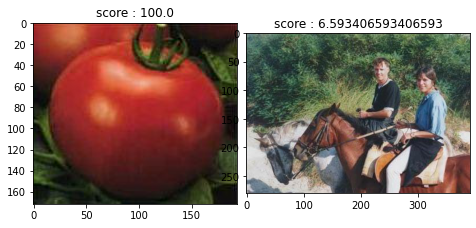

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
res_cnt = len(result)
plt.figure(1, figsize=(20,10))
for i in range(res_cnt+1):
  if i < res_cnt:
    plots = "3"+"5"+str(i+1)
    path = result[i]['file_path']
    plt.subplot(plots)
    plt.title("score : " + str(result[i]['score']))
    img = mpimg.imread(path)
    plt.imshow(img)

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

ValueError: ignored

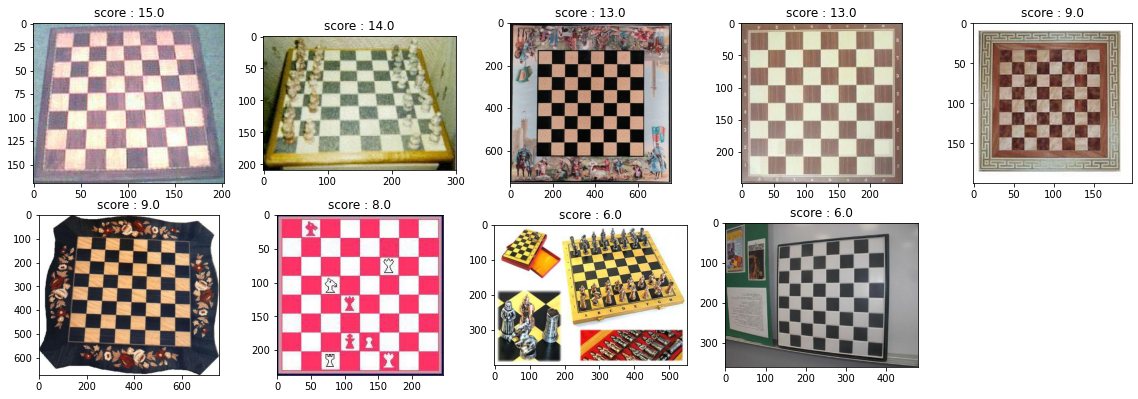

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
res_cnt = len(result)
plt.figure(1, figsize=(20,10))
for i in range(res_cnt+1):
  if i < res_cnt:
    plots = "3"+"5"+str(i+1)
    path = result[i]['file_path']
    plt.subplot(plots)
    plt.title("score : " + str(result[i]['score']))
    img = mpimg.imread(path)
    plt.imshow(img)

plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

In [ ]:
result[0]['neighbors'][2]['file_path']